In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Import modules:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime
from sklearn import preprocessing
from sklearn.cluster import KMeans,DBSCAN
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from pandas.core.common import random_state
from sklearn.metrics import silhouette_score
pd.set_option('display.max_columns', None)  

In [ ]:
path = '/content/gdrive/MyDrive/Data/bank_transactions.csv'

In [ ]:
#Read dataset: 
df = pd.read_csv(path)
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


## 1. Data preparation:

In [ ]:
df.info() #There is no null values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


In [ ]:
#Check na values:
df.isna().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

In [ ]:
df = df.dropna()

In [ ]:
df['CustomerID'].value_counts()
df['TransactionID'].value_counts()
#CustomerID duplicated while TransactionID is not

T1          1
T699342     1
T699328     1
T699329     1
T699330     1
           ..
T349709     1
T349710     1
T349711     1
T349712     1
T1048567    1
Name: TransactionID, Length: 1041614, dtype: int64

In [ ]:
df['CustomerID'].nunique()

879358

In [ ]:
df['TransactionDate'].nunique()

55

In [ ]:
#CustDOB:
df['CustomerDOB'].value_counts()
#56292 values with YOB is 1800 before converting to datetime

1/1/1800    56292
1/1/89        809
1/1/90        784
6/8/91        698
1/1/91        665
            ...  
2/12/51         1
20/3/52         1
26/9/47         1
4/10/41         1
24/10/44        1
Name: CustomerDOB, Length: 17233, dtype: int64

In [ ]:
df = df.drop(df[df['CustomerDOB'] == '1/1/1800'].index, axis = 0)

In [ ]:
#Gender: 
df['CustGender'].value_counts() #M ~ 3F, T?

M    712454
F    272868
Name: CustGender, dtype: int64

In [ ]:
#Custlocation: 
df['CustLocation'].value_counts()

MUMBAI                       97679
BANGALORE                    77751
NEW DELHI                    76380
GURGAON                      70518
DELHI                        67335
                             ...  
KAMALPUR                         1
JUFFAIR                          1
CHAKALA ANDHERI -E MUMBAI        1
CORPORATION THANE                1
IMPERIA THANE WEST               1
Name: CustLocation, Length: 8164, dtype: int64

In [ ]:
df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB']) #convert data to datetime

In [ ]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

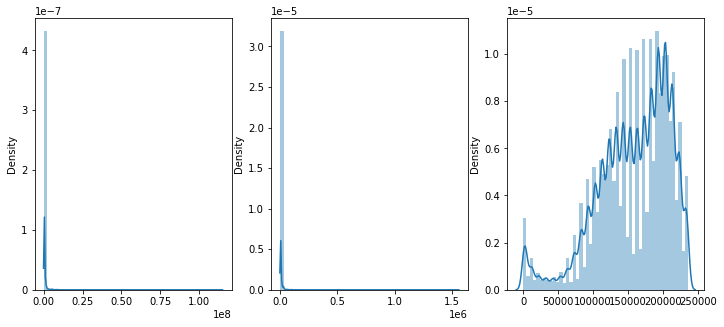

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12,5))
sns.distplot(x=df['CustAccountBalance'], ax = ax[0])
sns.distplot(x=df['TransactionAmount (INR)'], ax = ax[1])
sns.distplot(x=df['TransactionTime'], ax = ax[2])
plt.show()

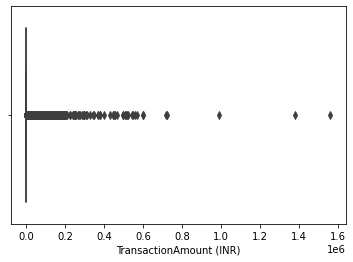

In [ ]:
sns.boxplot(x=df['TransactionAmount (INR)'])

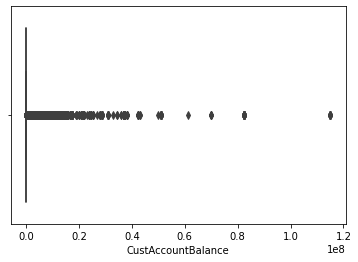

In [ ]:
sns.boxplot(x=df['CustAccountBalance'])

In [ ]:
#Create rfm df: 
df_rfm = df
#RFM: 
recent_date = max(df['TransactionDate']) + datetime.timedelta(days=1)

df_rfm = df_rfm.groupby(['CustomerID']).agg(
    {
      'TransactionDate':lambda x: (recent_date - x.max()).days,  
      'CustomerID':'count',
      'TransactionAmount (INR)':'sum'
    }
)

In [ ]:
df_rfm.columns = ['Recency','Frequency','Monetary']
df_rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
C1010011,75,2,5106.0
C1010012,118,1,1499.0
C1010014,155,2,1455.0
C1010018,86,1,30.0
C1010024,114,1,5000.0


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

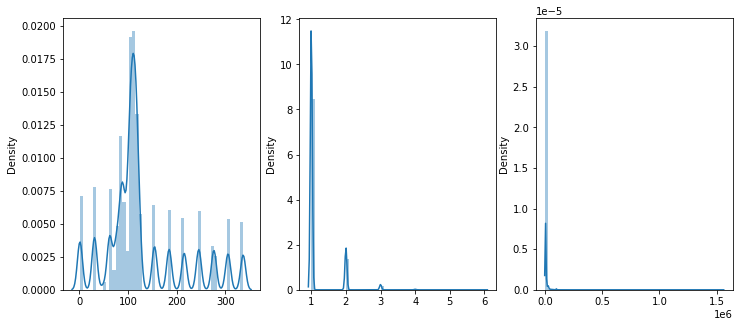

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12,5))
sns.distplot(x=df_rfm['Recency'], ax = ax[0])
sns.distplot(x=df_rfm['Frequency'], ax = ax[1])
sns.distplot(x=df_rfm['Monetary'], ax = ax[2])
plt.show()

In [ ]:
from scipy import stats
#transform data:
def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    sns.distplot(df_rfm[x], ax=ax[0,0])
    #log:
    sns.distplot(np.log(df_rfm[x]), ax=ax[0,1])
    #sqrt:
    sns.distplot(np.sqrt(df_rfm[x]), ax=ax[1,0])
    #boxcox:
    sns.distplot(stats.boxcox(df_rfm[x])[0], ax=ax[1,1])
    plt.tight_layout()
    plt.show()
    
    print(df_rfm[x].skew().round(2))
    print(np.log(df_rfm[x]).skew().round(2))
    print(np.sqrt(df_rfm[x]).skew().round(2))
    print(pd.Series(stats.boxcox(df_rfm[x])[0]).skew().round(2))

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

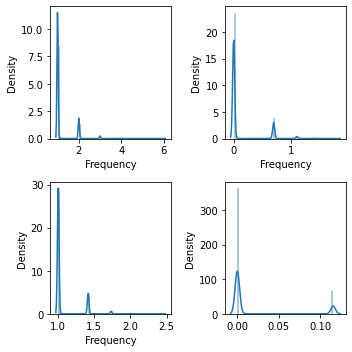

2.66
2.15
2.34
1.92


In [ ]:
analyze_skewness('Frequency')

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

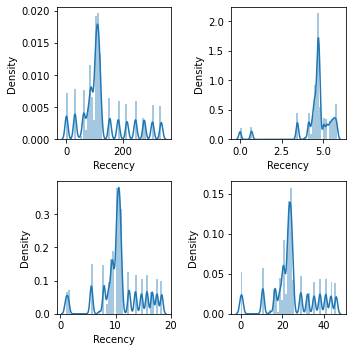

1.01
-2.71
-0.21
0.03


In [ ]:
analyze_skewness('Recency') 

In [ ]:
#Transform: 
df_rfm_t = pd.DataFrame()
df_rfm_t['Recency'] = stats.boxcox(df_rfm['Recency'])[0]
df_rfm_t['Frequency'] = stats.boxcox(df_rfm['Frequency'])[0]
df_rfm_t['Monetary'] = pd.Series(np.cbrt(df_rfm['Monetary'])).values
df_rfm_t.head(10)

,Recency,Frequency,Monetary
0,18.588410,0.115904,17.219754
1,24.542427,0.000000,11.444598
2,28.935446,0.115904,11.331507
3,20.228334,0.000000,3.107233
4,24.033726,0.000000,17.099759
5,22.593300,0.000000,8.227825
6,38.112286,0.115904,12.306899
7,22.859985,0.115904,9.085603
8,22.992500,0.000000,5.924992
9,21.224702,0.000000,26.998628


In [ ]:
# Scaling data
# Instantiate
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_rfm_t)
df_rfm_t = scaler.transform(df_rfm_t)

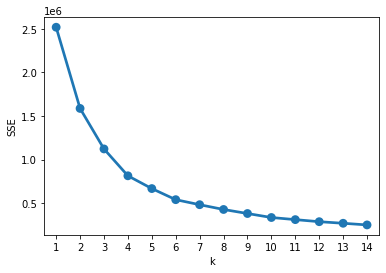

In [ ]:
#Elbow
import random

sse = {}
for k in range(1,15): 
  kmeans = KMeans(n_clusters=k, random_state = 42)
  kmeans.fit(df_rfm_t) 
  sse[k] = kmeans.inertia_ 

plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()),y=list(sse.values()))
plt.show()

In [ ]:
# kmeans_per_k = [KMeans(n_clusters = k, random_state=42).fit(rfm_df_scaled) for k in range(1, 10)]
# silhouette_scores = [silhouette_score(rfm_df_scaled, x.labels_) for x in kmeans_per_k[1:]]
# range_n_clusters = [ 2, 3, 4, 5, 6, 7, 8, 9]
# plt.figure(figsize=(16,8))
# plt.plot(range_n_clusters, silhouette_scores, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Silhouette score')
# plt.title('Silhouette score result')
# plt.show()

In [ ]:
#Model:
model = KMeans(n_clusters=4, random_state=42)
model.fit(df_rfm_t)

KMeans(n_clusters=4, random_state=42)

In [ ]:
df_rfm_km = df_rfm
df_rfm_km['Cluster'] = model.labels_
df_rfm_km.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
C1010011,75,2,5106.0,2
C1010012,118,1,1499.0,1
C1010014,155,2,1455.0,2
C1010018,86,1,30.0,1
C1010024,114,1,5000.0,0


In [ ]:
pip install kmodes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## RFM model:

In [ ]:
# def RScore(x,p,d): 
#   if x <= d[p][0.25]: 
#     return 1 
#   elif x <= d[p][0.5]: 
#     return 2
#   elif x <= d[p][0.75]:
#     return 3
#   else: 
#     return 4
# def FnMScore(x,p,d):
#   if x <= d[p][0.25]:
#     return 4
#   elif x <= d[p][0.5]:
#     return 3
#   elif x <= d[p][0.75]:
#     return 2
#   else: 
#     return 1 

Cluster with RFM (quarterly)

In [ ]:
# df_rfm_score = df_rfm

In [ ]:
# quantiles = df_rfm_score.quantile(q=[0.25,0.5,0.75])
# quantiles = quantiles.to_dict()

In [ ]:
# quantiles

In [ ]:
# df_rfm_score['R'] = df_rfm_score['Recency'].apply(RScore, args=('Recency',quantiles,))
# df_rfm_score['F'] = df_rfm_score['Frequency'].apply(FnMScore, args=('Frequency',quantiles,))
# df_rfm_score['M'] = df_rfm_score['Monetary'].apply(FnMScore, args=('Monetary',quantiles,))

In [ ]:
# df_rfm_score.head()

In [ ]:
# #Calculate RFM total score:
# df_rfm_score['RFM_Score'] = df_rfm_score['R'] + df_rfm_score['F'] + df_rfm_score['M']

In [ ]:
# df_rfm_score['RFM_Group'] = df_rfm_score['R'].map(str) + df_rfm_score['F'].map(str) + df_rfm_score['M'].map(str)

In [ ]:
# cust_label = ['Platinum','Gold','Silver','Bronze'] 
# score_cuts = pd.qcut(df_rfm_score.RFM_Score,q=4,labels=cust_label)
# df_rfm_score['Cust_label'] = score_cuts.values

In [ ]:
# df_rfm_score.head()

In [ ]:
# df_rfm_score.head()

In [ ]:
# encode = df_rfm_score

In [ ]:
# encode = encode.drop(columns=['R','F','M','RFM_Score','RFM_Group'])

In [ ]:
# encode.head()

In [ ]:
# encode['Cust_label'] = encode['Cust_label'].replace(['Platinum','Gold','Silver','Bronze'],[0,1,2,3])

In [ ]:
# encode.head()

In [ ]:
# encode = encode.reset_index()

## Auto ARIMA: 

In [ ]:
# #Matching data: 
# df = df.merge(encode[['CustomerID','Cust_label']])

In [ ]:
# print(max(df['TransactionDate']))
# print(min(df['TransactionDate']))
# #Check transactiondate range

In [ ]:
# df.head()

In [ ]:
# df_2 = df[['CustomerID','TransactionDate','TransactionAmount (INR)','Cust_label']]

In [ ]:
# df_2.head()

In [ ]:
# df_total = df_2[['TransactionDate','TransactionAmount (INR)']]
# df_total = df_total.groupby(df_total['TransactionDate'].dt.date)['TransactionAmount (INR)'].sum()

In [ ]:
# df_total

In [ ]:
# #Split dataset base on customer level: 
# #Platinum: 
# df_platinum = df_2.loc[df['Cust_label']==0]
# # df_platinum = df_platinum[['TransactionDate','TransactionAmount (INR)']]
# # df_platinum = df_platinum.groupby(df_platinum['TransactionDate'].dt.date)['TransactionAmount (INR)'].sum()
# #Gold: 
# df_gold = df_2.loc[df['Cust_label']==1]
# # df_gold = df_gold[['TransactionDate','TransactionAmount (INR)']]
# # df_gold = df_gold.groupby(df_gold['TransactionDate'].dt.date)['TransactionAmount (INR)'].sum()
# #Silver: 
# df_silver = df_2.loc[df['Cust_label']==2]
# # df_silver = df_silver[['TransactionDate','TransactionAmount (INR)']] 
# # df_silver = df_silver.groupby(df_silver['TransactionDate'].dt.date)['TransactionAmount (INR)'].sum()
# #Bronze: 
# df_bronze = df_2.loc[df['Cust_label']==3]
# # df_bronze = df_bronze[['TransactionDate','TransactionAmount (INR)']] 
# # df_bronze = df_bronze.groupby(df_bronze['TransactionDate'].dt.date)['TransactionAmount (INR)'].sum()

In [ ]:
# df_platinum.head()

In [ ]:
# # install pmdarima to use Auto Arima model: 
# !pip install pmdarima #--> this package allows to run ARIMA model forecasting automatically

In [ ]:
# #import modules: 
# from statsmodels.tsa.arima_model import ARIMA
# import pmdarima as pm

In [ ]:
# model = pm.auto_arima(df_total, start_p=1, start_q=1,
#                       test='adf',       # use adftest to find optimal 'd'
#                       max_p=3, max_q=3, # maximum p and q
#                       m=1,              # frequency of series
#                       d=None,           # let model determine 'd'
#                       seasonal=False,   # No Seasonality
#                       start_P=0, 
#                       D=0, 
#                       trace=True,
#                       error_action='ignore',  
#                       suppress_warnings=True, 
#                       stepwise=True)

# print(model.summary())

## K-prototype:

In [ ]:
df_rfm_kp = df_rfm
df_rfm_kp = df_rfm_kp.reset_index()

In [ ]:
df_rfm_kp.head()

,CustomerID,Recency,Frequency,Monetary,CustGender
0,C1010011,18.597147,0.241975,17.219754,1
1,C1010011,18.597147,0.241975,17.219754,0
2,C1010012,24.555468,0.000000,11.444598,0
3,C1010014,28.951912,0.241975,11.331507,1
4,C1010014,28.951912,0.241975,11.331507,0


In [ ]:
df_rfm_kp = df_rfm_kp.merge(df[['CustomerID','CustGender']])

In [ ]:
#encode:
df_rfm_kp['CustGender'] = df_rfm_kp['CustGender'].replace(['M','F'],[0,1])

In [ ]:
# df_rfm_kp = df_rfm_kp.drop(columns = 'Cluster')
df_rfm_kp_t = df_rfm_kp

In [ ]:
df_rfm_kp_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 985322 entries, 0 to 985321
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   CustomerID  985322 non-null  object 
 1   Recency     985322 non-null  float64
 2   Frequency   985322 non-null  float64
 3   Monetary    985322 non-null  float64
 4   CustGender  985322 non-null  int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 45.1+ MB


In [ ]:
#Transform:
df_rfm_kp_t['Recency'] = stats.boxcox(df_rfm_kp['Recency'])[0]
df_rfm_kp_t['Frequency'] = stats.boxcox(df_rfm_kp['Frequency'])[0]
df_rfm_kp_t['Monetary'] = pd.Series(np.cbrt(df_rfm_kp['Monetary'])).values

In [ ]:
df_rfm_kp_t = df_rfm_kp_t.set_index('CustomerID')

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_rfm_kp_t)
df_rfm_kp_t = scaler.transform(df_rfm_kp_t)

In [ ]:
df_rfm_kp_t[0:][0:]

,CustomerID,Recency,Frequency,Monetary,CustGender
0,C1010011,18.597147,0.241975,17.219754,1
1,C1010011,18.597147,0.241975,17.219754,0
2,C1010012,24.555468,0.000000,11.444598,0
3,C1010014,28.951912,0.241975,11.331507,1
4,C1010014,28.951912,0.241975,11.331507,0
...,...,...,...,...,...
985317,C9099836,28.951912,0.000000,8.840823,0
985318,C9099877,20.238213,0.000000,6.055049,0
985319,C9099919,24.046383,0.000000,5.013298,0
985320,C9099941,22.738605,0.000000,3.684031,0


In [ ]:
df_rfm_kp_t.info()

AttributeError: ignored

In [ ]:
from kmodes.kprototypes import KPrototypes

kproto_clusters = KPrototypes(n_clusters=4,random_state=7,init="Huang")
df_rfm_kp['Cluster'] = kproto_clusters.fit_predict(df_rfm_kp_t,
                                                   categorical = [0,1,2,3])

AssertionError: ignored